In [68]:
from collections import Counter, defaultdict
from functools import partial
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample

plt.rcParams["figure.autolayout"] = True


# Important: File output and hyperparameter range configuration

Set `full = True` to test the entire range of hyperparameters to tune. **This will take approx 12 minutes to run on Ed.** Please keep the Ed window in the foregound to prevent it from sleeping.
Around 8 minutes of this cost comes from tuning the optimum number of features by using top-k features mutual selection feature selection for each _fold_ to prevent data leakage at the cost of longer computation time. That's 27 * 5 = 135 times that we attempt to select the top k MIs - with many more mutual information calculations that that!

Set `full = False` to only test a limited range of hyperparameters near the optimum that we have determined. **This will take ~ 4 minutes to run on Ed.**

Output files:

- `out_full/**`: results of testing on full range of hyperparameters. These plots are generated for the report.
- `out_static/**`: a frozen copy of out_full. This contains the plots that are included in the report PDF.
- `out_fast/**`: results of testing on a limited range of hyperparameters. Some plots will not be useful e.g. comparing performance across hyperparameters in KNN.


In [69]:
# Set the full flag here.
full = False


## Helpers for file output


In [70]:
if not isinstance(full, bool):
    full = False

PATH_FULL = "out_full"
PATH_FAST = "out_fast"

Path(PATH_FULL).mkdir(parents=True, exist_ok=True)
Path(PATH_FAST).mkdir(parents=True, exist_ok=True)


def make_output_path(filename: str) -> str:
    return os.path.join(PATH_FULL if full else PATH_FAST, filename)


# Data Wrangling


In [71]:
df = pd.read_csv("/course/a2/security/UNSW_NB15_dataset.csv")
ex = df.copy()
ex.dtypes


id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

In [72]:
ex.isna().any().isna().any()


False

In [73]:
# Found skewed features using ex.describe() and manual inspection.
skewed_features = [
    "dur",
    "spkts",
    "dpkts",
    "sbytes",
    "dbytes",
    "rate",
    "sload",
    "dload",
    "sinpkt",
    "dinpkt",
    "sjit",
    "djit",
]

ex[skewed_features].describe()


,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sinpkt,dinpkt,sjit,djit
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,6.454902e+07,6.305470e+05,755.394301,121.701284,6.363075e+03,535.180430
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,1.798618e+08,2.393001e+06,6182.615732,1292.378499,5.672402e+04,3635.305383
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,1.120247e+04,0.000000e+00,0.008000,0.000000,0.000000e+00,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,5.770032e+05,2.112951e+03,0.557929,0.010000,1.762392e+01,0.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,6.514286e+07,1.585808e+04,63.409444,63.136369,3.219332e+03,128.459914
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,5.268000e+09,2.082111e+07,60009.992000,57739.240000,1.483831e+06,463199.240100


In [74]:
# ex[[x for x in skewed_features if x != 'sload']].plot.box()
# ex[skewed_features] = ex[skewed_features].apply(lambda x: np.log2(x + 1))
# ex.isna().any().isna().any()


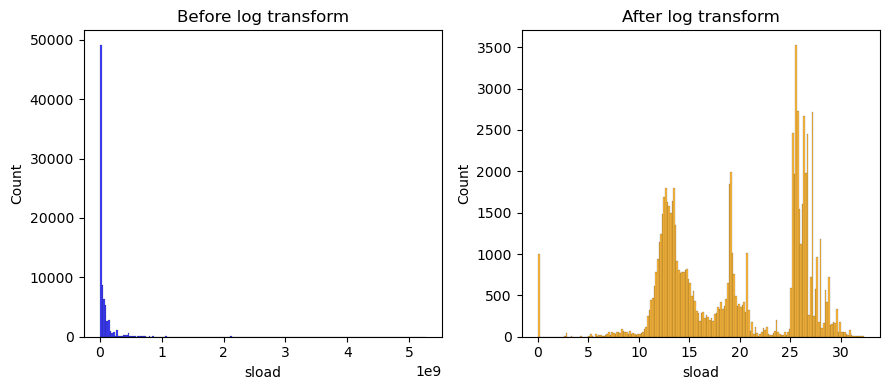

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
f_h = "sload"
ax = axs[0]
sns.histplot(ex[f_h], bins=200, color="blue", ax=ax)
ax.set_title("Before log transform")

ax = axs[1]
sns.histplot(np.log2(ex[f_h] + 1), bins=200, color="orange", ax=ax)
ax.set_title("After log transform")
plt.savefig(make_output_path("log_transform_demo.png"))
plt.show()


In [76]:
ex["attack_cat"].value_counts(normalize=True)


Normal            0.449400
Generic           0.229206
Exploits          0.135209
Fuzzers           0.073629
DoS               0.049665
Reconnaissance    0.042462
Analysis          0.008223
Backdoor          0.007081
Shellcode         0.004591
Worms             0.000534
Name: attack_cat, dtype: float64

In [77]:
ex[["proto", "service", "state"]].nunique()


proto      131
service     13
state        7
dtype: int64

In [78]:
ex["service"].value_counts(normalize=True).head()


-       0.572718
dns     0.259522
http    0.100653
smtp    0.022482
ftp     0.018851
Name: service, dtype: float64

In [79]:
ex["proto"].value_counts(normalize=True).head()


tcp     0.523430
udp     0.357309
unas    0.042693
arp     0.011988
ospf    0.008211
Name: proto, dtype: float64

In [80]:
ex["state"].value_counts(normalize=True)


FIN    0.477809
INT    0.414942
CON    0.084803
REQ    0.022373
ACC    0.000049
RST    0.000012
CLO    0.000012
Name: state, dtype: float64

In [81]:
ex.loc[~ex["service"].isin(["-", "dns", "http"]), "service"] = "-"
ex["service"].value_counts(normalize=True)


-       0.639824
dns     0.259522
http    0.100653
Name: service, dtype: float64

In [82]:
ex.loc[~ex["proto"].isin(["tcp", "udp"]), "proto"] = "other"
ex["proto"].value_counts(normalize=True)


tcp      0.523430
udp      0.357309
other    0.119261
Name: proto, dtype: float64

In [83]:
ex.loc[ex["attack_cat"] != "DoS", "attack_cat"] = "Other"
ex["attack_cat"].value_counts(normalize=True)


Other    0.950335
DoS      0.049665
Name: attack_cat, dtype: float64

In [84]:
from sklearn.preprocessing import OneHotEncoder

serviceEncoder = OneHotEncoder(drop="first", sparse=False)
z = serviceEncoder.fit_transform(ex[["service"]])
print(serviceEncoder.categories_)
ex[["service_dns", "service_http"]] = z

protoEncoder = OneHotEncoder(drop="first", sparse=False)
z = protoEncoder.fit_transform(ex[["proto"]])
print(protoEncoder.categories_)
ex[["proto_tcp", "proto_udp"]] = z

ex = ex.drop(["proto", "service"], axis=1)


[array(['-', 'dns', 'http'], dtype=object)]
[array(['other', 'tcp', 'udp'], dtype=object)]


In [85]:
ex = ex.drop(
    ["stcpb", "dtcpb", "synack", "ackdat", "ct_state_ttl", "state", "label", "id"],
    axis=1,
)


In [86]:
print(len(ex.columns))
ex.columns


39


Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'dwin', 'tcprtt', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports',
       'attack_cat', 'service_dns', 'service_http', 'proto_tcp', 'proto_udp'],
      dtype='object')

# Partition data into a holdout set for final model evaluation & to prevent data leakage


In [87]:
target = "attack_cat"
features_1 = ex.drop([target], axis=1).columns.tolist()
len(features_1)


38

In [88]:
X = ex[features_1]
y = ex[target]
X, X_holdout, y, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)


# Feature correlation and some feature selection and engineering


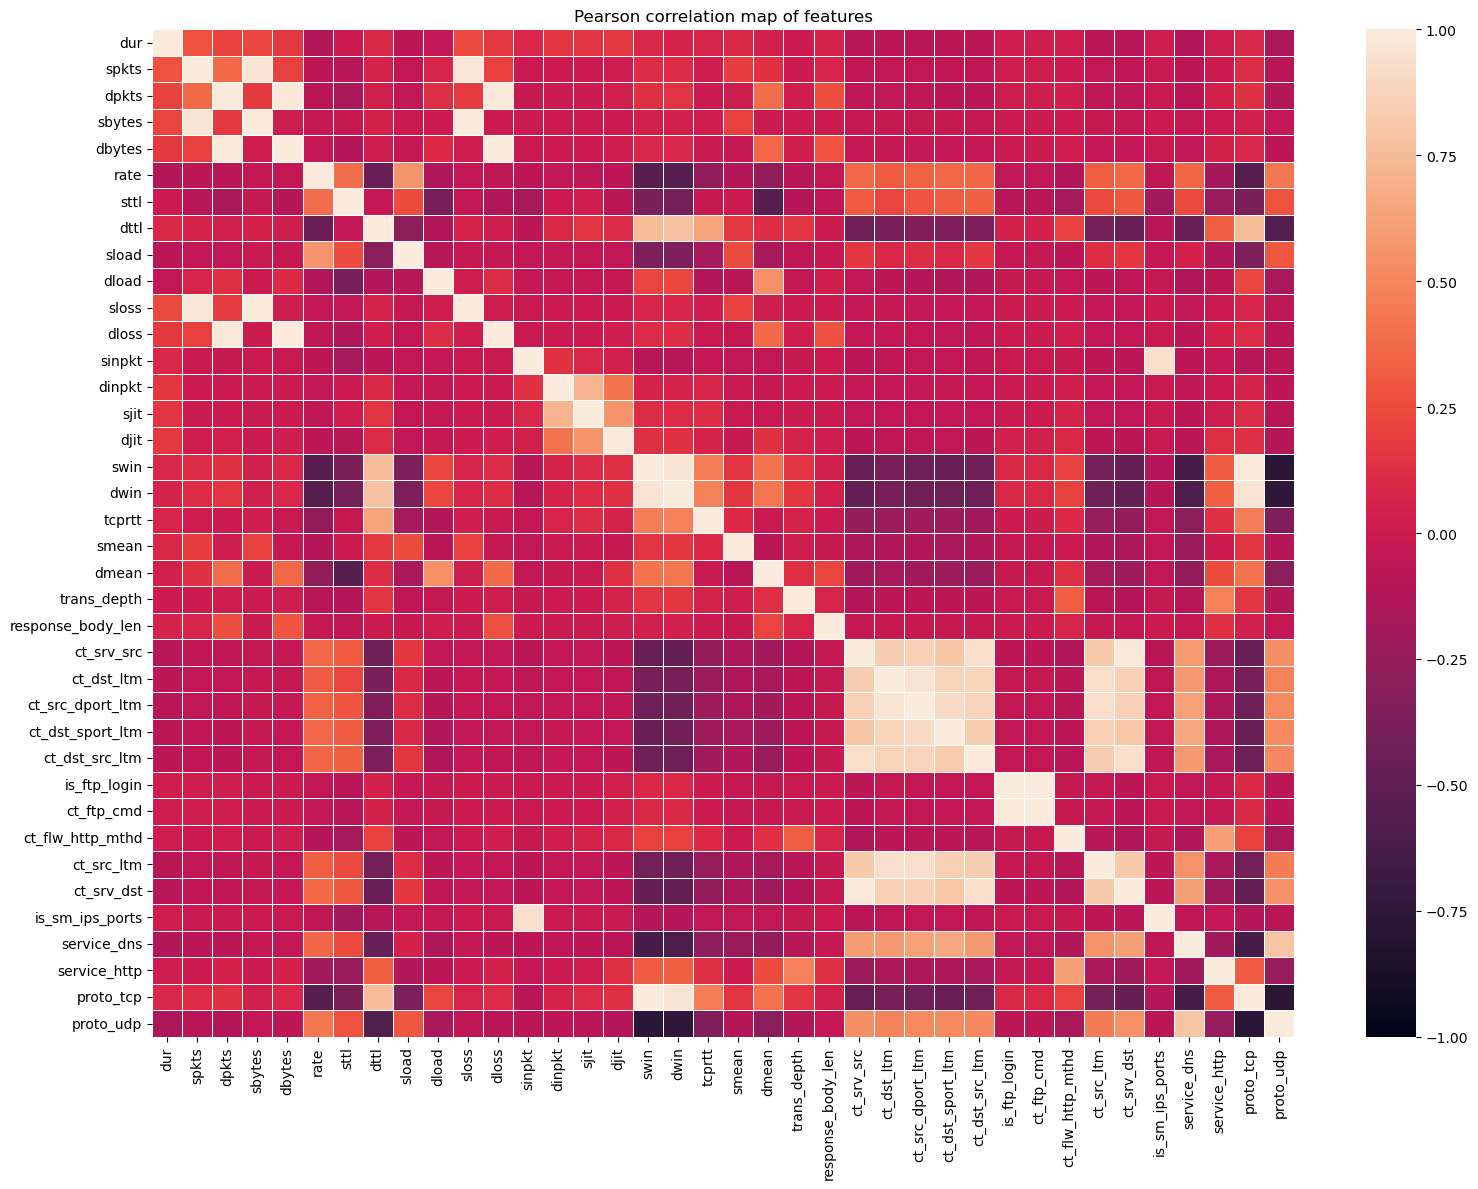

In [89]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(
    X[features_1].corr(),
    linewidth=0.5,
    xticklabels=1,
    yticklabels=1,
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Pearson correlation map of features")
plt.show()


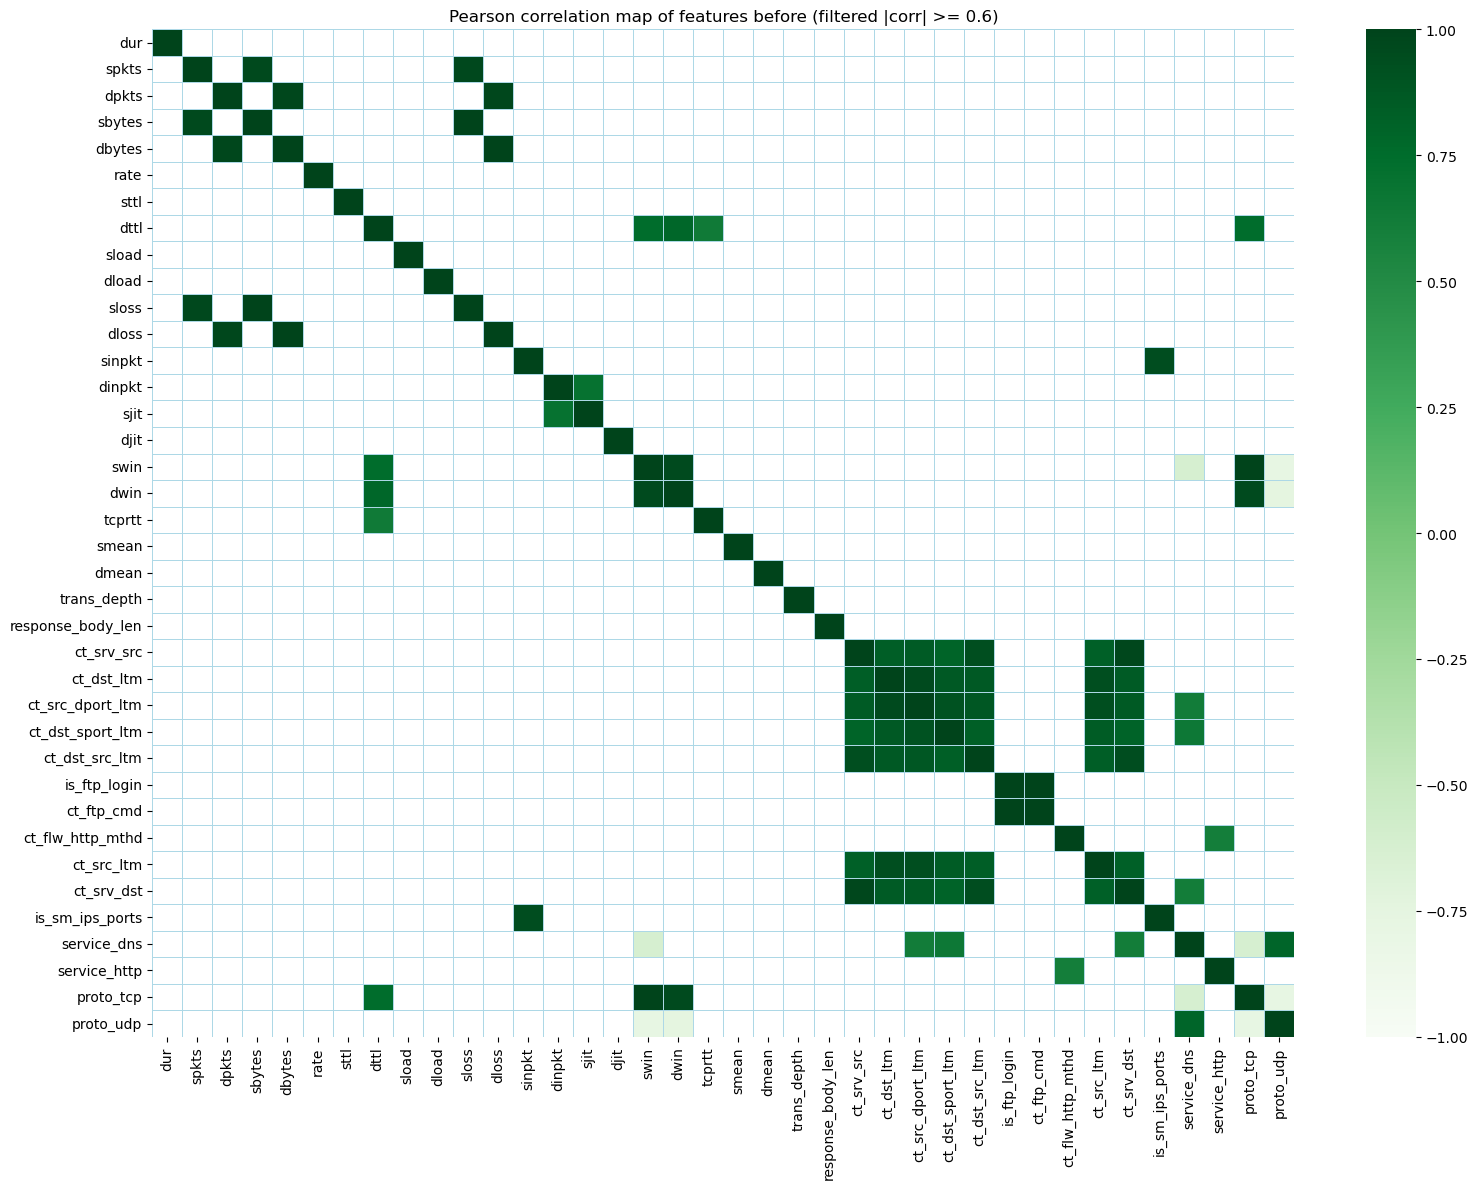

In [90]:
fig, ax = plt.subplots(figsize=(16, 12))
corr = X.corr()
corr_filtered = corr[abs(corr) >= 0.6]
sns.heatmap(
    corr_filtered,
    cmap="Greens",
    ax=ax,
    vmin=-1,
    vmax=1,
    linewidth=0.5,
    xticklabels=1,
    yticklabels=1,
    linecolor="lightblue",
)
ax.set_title("Pearson correlation map of features before (filtered |corr| >= 0.6)")
plt.savefig(make_output_path("corr_before.png"))
plt.show()


In [91]:
X


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,service_dns,service_http,proto_tcp,proto_udp
21676,0.000008,2,0,114,0,125000.000300,254,0,5.700000e+07,0.000000,...,0,0,0,33,33,0,1.0,0.0,0.0,1.0
45516,0.806984,10,6,592,268,18.587729,254,252,5.283872e+03,2220.614014,...,0,0,0,2,3,0,0.0,0.0,1.0,0.0
47458,0.000010,2,0,344,0,100000.002500,254,0,1.376000e+08,0.000000,...,0,0,0,1,1,0,0.0,0.0,0.0,1.0
18516,0.000008,2,0,114,0,125000.000300,254,0,5.700000e+07,0.000000,...,0,0,0,11,29,0,1.0,0.0,0.0,1.0
48323,0.276639,10,6,742,268,54.222287,254,252,1.931759e+04,6477.755859,...,0,0,1,1,1,0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30115,0.131321,4,4,568,304,53.304499,31,29,2.595168e+04,13889.629880,...,0,0,0,3,6,0,0.0,0.0,0.0,1.0
49361,0.875466,10,6,534,268,17.133732,254,252,4.395374e+03,2046.909912,...,0,0,0,1,5,0,0.0,0.0,1.0,0.0
43723,0.000011,2,0,168,0,90909.090200,254,0,6.109091e+07,0.000000,...,0,0,0,2,1,0,0.0,0.0,0.0,1.0
2946,0.000005,2,0,200,0,200000.005100,254,0,1.600000e+08,0.000000,...,0,0,0,21,5,0,0.0,0.0,0.0,0.0


In [92]:
ex = ex.drop(
    [
        "service_dns",
        "service_http",
        "proto_tcp",
        "proto_udp",
        "is_ftp_login",
        "is_sm_ips_ports",
    ],
    axis=1,
)


In [93]:
ex = ex.drop(["ct_srv_src", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm"], axis=1)


In [94]:
ex["slossrate"] = ex["sloss"] / ex["spkts"]
print(ex["slossrate"].isna().any())
ex = ex.drop(["sloss"], axis=1)
ex["slossrate"].describe()


False


count    82332.000000
mean         0.129934
std          0.149962
min          0.000000
25%          0.000000
50%          0.100000
75%          0.200000
max          1.407609
Name: slossrate, dtype: float64

Apply initial feature filtering + engineering to both train and holdout test sets (this does not cause data leakage since we did not perform aggregation of data across both train and holdout test sets e.g. median)

In [95]:
features_1 = ex.drop([target], axis=1).columns.tolist()
X = ex[features_1]
y = ex[target]
X, X_holdout, y, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)


In [96]:
pairs = X.corr().unstack().sort_values().drop_duplicates()
pairs = pd.DataFrame(pairs, columns=["corr"])
pairs[abs(pairs["corr"]) > 0.6]


,,corr
slossrate,dttl,0.600499
tcprtt,dttl,0.639103
dwin,slossrate,0.698921
sjit,dinpkt,0.705617
dttl,swin,0.749304
dwin,dttl,0.781505
ct_srv_dst,ct_dst_sport_ltm,0.811084
swin,slossrate,0.827955
ct_dst_sport_ltm,ct_dst_src_ltm,0.831403
ct_dst_src_ltm,ct_srv_dst,0.941153


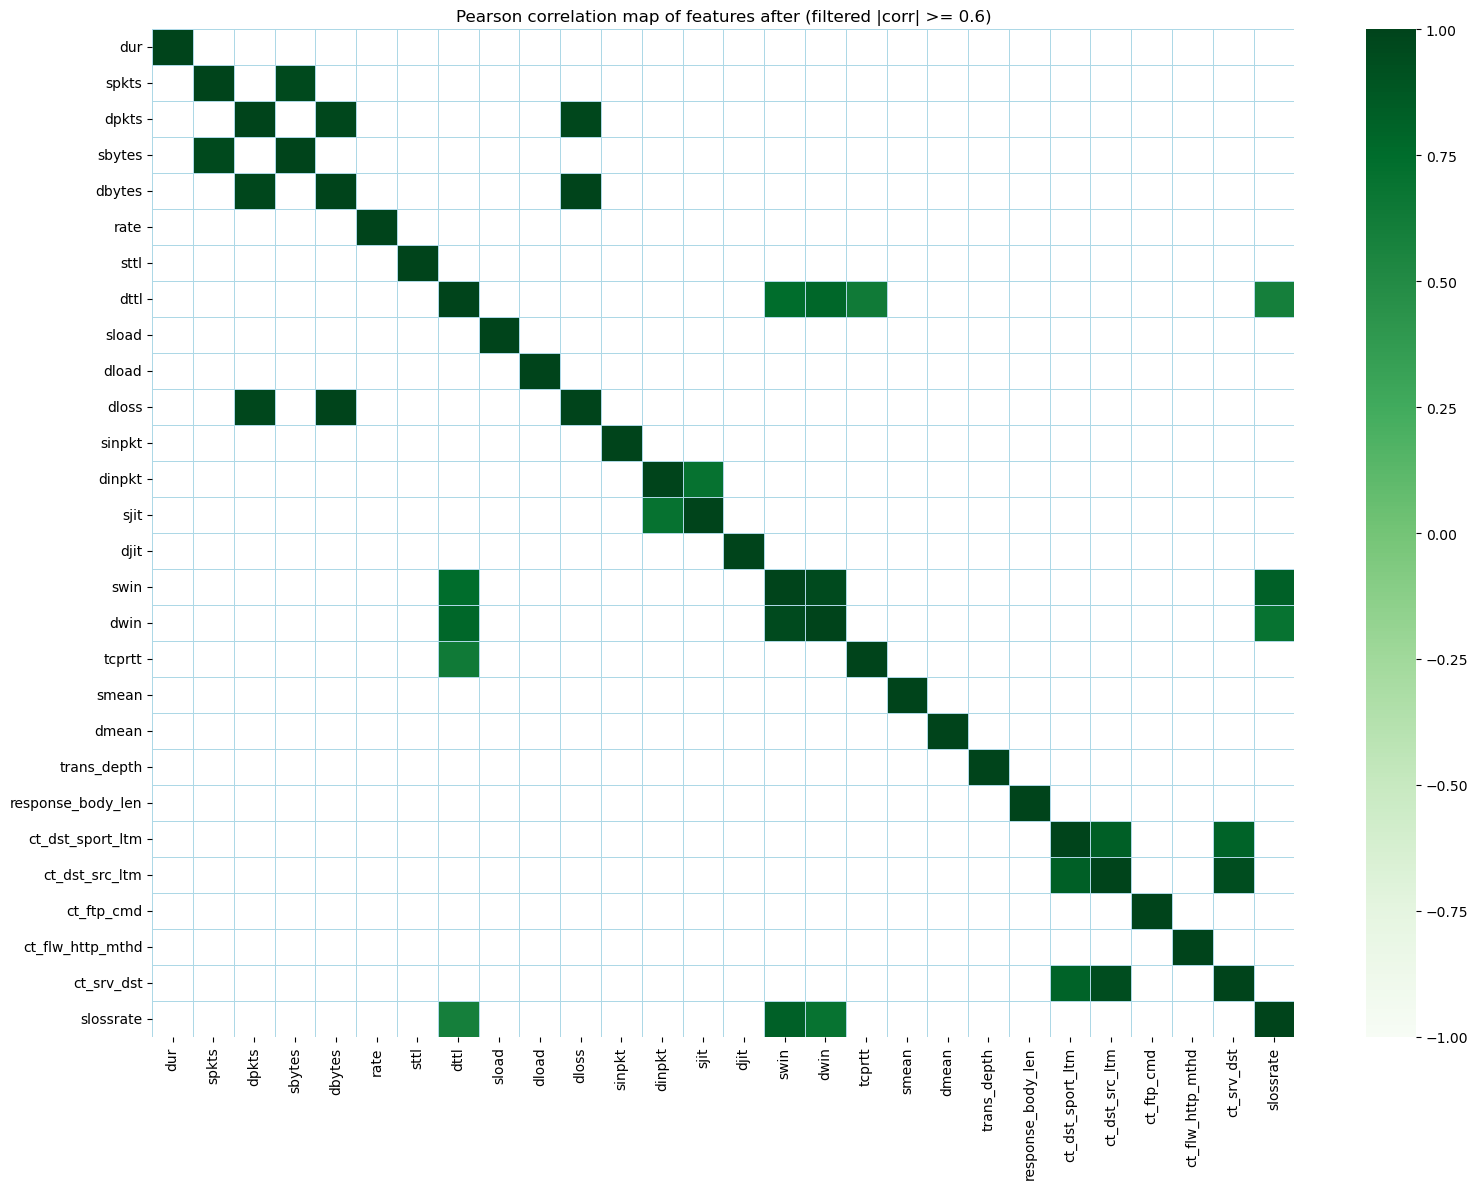

In [97]:
fig, ax = plt.subplots(figsize=(16, 12))
corr = X.corr()
corr_filtered = corr[abs(corr) >= 0.6]
sns.heatmap(
    corr_filtered,
    cmap="Greens",
    ax=ax,
    vmin=-1,
    vmax=1,
    linewidth=0.5,
    xticklabels=1,
    yticklabels=1,
    linecolor="lightblue",
)
ax.set_title("Pearson correlation map of features after (filtered |corr| >= 0.6)")
plt.savefig(make_output_path("corr_after.png"))
plt.show()


In [98]:
X.columns


Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin',
       'dwin', 'tcprtt', 'smean', 'dmean', 'trans_depth', 'response_body_len',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_srv_dst', 'slossrate'],
      dtype='object')

In [99]:
ex.isna().any().isna().any()


False

# Model Evaluation Helpers


In [100]:
my_mutual_info_classif = partial(mutual_info_classif, random_state=1)


In [101]:
def new_k_results():
    results = {
        "accuracy": [],
        "balanced_acc": [],
        "precision": [],
        "recall": [],
        "f1": [],
    }
    return results


In [102]:
def append_score(results, y_test, y_pred):
    results["accuracy"].append(accuracy_score(y_test, y_pred))
    results["balanced_acc"].append(balanced_accuracy_score(y_test, y_pred))

    # Set metrics to 0 if attempt to divide by 0: aka no predicted positives (precision),
    # or true positives (recall) in the denominator.
    results["precision"].append(
        precision_score(y_test, y_pred, pos_label="DoS", zero_division=0)
    )
    results["recall"].append(
        recall_score(y_test, y_pred, pos_label="DoS", zero_division=0)
    )
    results["f1"].append(f1_score(y_test, y_pred, pos_label="DoS", zero_division=0))


In [103]:
labels = ["DoS", "Other"]


In [104]:
def get_cv_metrics_df(all_results):
    df_results = pd.DataFrame.from_dict(all_results, orient="index")
    metrics = df_results.columns.tolist()
    df_results = df_results.reset_index().rename(columns={"index": "max_depth"})
    for m in metrics:
        df_results[f"{m}_std"] = df_results[m].apply(np.std)
        df_results[m] = df_results[m].apply(np.mean)
    return df_results


In [105]:
def plot_cv_results(df, out=None, title="", xlabel=""):
    metrics = ["accuracy", "balanced_acc", "precision", "recall", "f1"]
    colors = plt.cm.rainbow(np.linspace(0, 1, 6))
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.ylabel("Metric")
    plt.xlabel(xlabel)
    plt.ylim([0, 1])

    for m, c in zip(metrics, colors):
        plt.plot(df["max_depth"].apply(str), df[m], color=c, marker=".")

    plt.legend(metrics, bbox_to_anchor=(1.01, 1))

    for m, c in zip(metrics, colors):
        plt.fill_between(
            df["max_depth"].apply(str),
            df[m] - df[f"{m}_std"],
            df[m] + df[f"{m}_std"],
            alpha=0.1,
            color=c,
        )

    if out is not None:
        plt.savefig(make_output_path(out))
    plt.show()


# KNN


## Confirming an appropriate number of folds


In [106]:
all_results = {}
to_tune = range(3, 9) if full else range(4, 7)
for k_folds in to_tune:
    results = new_k_results()

    for state in range(2):
        kf_CV = KFold(n_splits=k_folds, shuffle=True, random_state=state)
        for train_idx, test_idx in kf_CV.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)

            # Use 3 neighbours for now as placeholder
            knn = KNN(n_neighbors=3)
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)

            append_score(results, y_test, y_pred)

    print(f"k_folds={k_folds}, ", end=" ")
    print({k: np.mean(v) for k, v in results.items()})
    all_results[k_folds] = results


k_folds=3,  {'accuracy': 0.9442116450315038, 'balanced_acc': 0.6482211856003012, 'precision': 0.4188549332955198, 'recall': 0.31960853679495665, 'f1': 0.362428263677175}
k_folds=4,  {'accuracy': 0.9442647902129875, 'balanced_acc': 0.6507254349507492, 'precision': 0.4203659349543982, 'recall': 0.32483145889720655, 'f1': 0.3663075780429025}
k_folds=5,  {'accuracy': 0.9444393835876415, 'balanced_acc': 0.652379271993824, 'precision': 0.4230794354801806, 'recall': 0.3281394494723279, 'f1': 0.3694266532089591}
k_folds=6,  {'accuracy': 0.9443938478628521, 'balanced_acc': 0.6509291067774828, 'precision': 0.4224432584281572, 'recall': 0.3251174613606412, 'f1': 0.3672047971154293}
k_folds=7,  {'accuracy': 0.9443938584524861, 'balanced_acc': 0.650792840618242, 'precision': 0.42243046046394206, 'recall': 0.3248213552235452, 'f1': 0.36699244210226867}
k_folds=8,  {'accuracy': 0.9446823250232532, 'balanced_acc': 0.6508208403567628, 'precision': 0.42582024979420463, 'recall': 0.3245751579967001, 'f1'

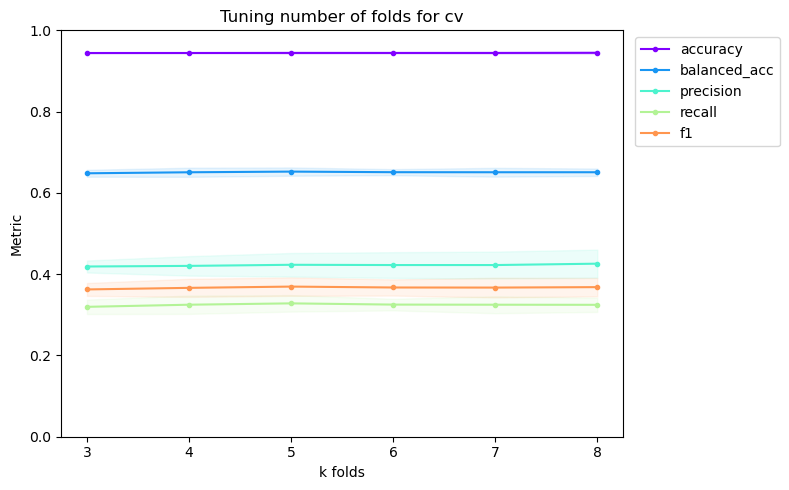

In [107]:
knn_results_0 = get_cv_metrics_df(all_results)

plot_cv_results(
    knn_results_0,
    title="Tuning number of folds for cv",
    xlabel="k folds",
    out="k_folds_verification.png",
)


# Tuning k-neighbours hyperparameter


In [108]:
k_folds = 5

to_tune = range(1, 8) if full else range(3, 6)
all_results = {}
for k_neighbors in to_tune:
    results = new_k_results()
    for state in range(2):
        kf_CV = KFold(n_splits=5, shuffle=True, random_state=state)
        for train_idx, test_idx in kf_CV.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)

            knn = KNN(n_neighbors=k_neighbors)
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)

            append_score(results, y_test, y_pred)

    print(f"k_neighbors={k_neighbors}, ", end=" ")
    print({k: np.mean(v) for k, v in results.items()})
    all_results[k_neighbors] = results


k_neighbors=1,  {'accuracy': 0.9375464966218781, 'balanced_acc': 0.6865240547048195, 'precision': 0.3802506850843924, 'recall': 0.40780063066715344, 'f1': 0.393088775227667}
k_neighbors=2,  {'accuracy': 0.9252182494496319, 'balanced_acc': 0.7514376104796935, 'precision': 0.3440169024799804, 'recall': 0.5584866205353377, 'f1': 0.4255035524541326}
k_neighbors=3,  {'accuracy': 0.9444393835876415, 'balanced_acc': 0.652379271993824, 'precision': 0.4230794354801806, 'recall': 0.3281394494723279, 'f1': 0.3694266532089591}
k_neighbors=4,  {'accuracy': 0.938571320124497, 'balanced_acc': 0.7039979784499462, 'precision': 0.3946731585231258, 'recall': 0.4435896551898777, 'f1': 0.41745332087363396}
k_neighbors=5,  {'accuracy': 0.94610946633265, 'balanced_acc': 0.6383971593121297, 'precision': 0.4368543697101643, 'recall': 0.2967471547506351, 'f1': 0.35279970315244286}
k_neighbors=6,  {'accuracy': 0.9435436119335003, 'balanced_acc': 0.6783911978953427, 'precision': 0.42362636093751344, 'recall': 0.3

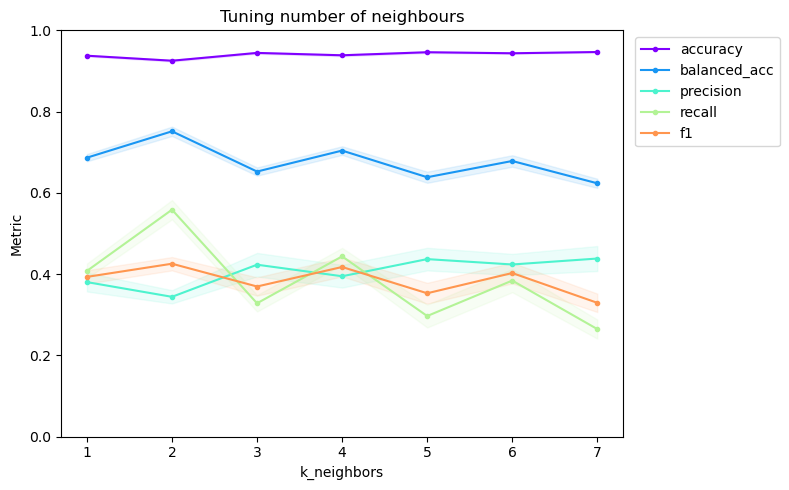

In [109]:
knn_results_2 = get_cv_metrics_df(all_results)

plot_cv_results(
    knn_results_2,
    title="Tuning number of neighbours",
    xlabel="k_neighbors",
    out="knn_k_neighbours_tuning.png",
)


## Tuning feature count hyperparameter, based on mutual information

Using sklearn's `mutual_info_classif` with built-in discretization.

Note that mutual_info_classif has a random_state parameter, which we populate to ensure reproducible results for the report.
See `my_mutual_info_classif` which uses functools partial function application to set the random_state.


In [110]:
k_neighbors = 4
k_folds = 5

to_tune = range(2, len(X.columns) + 1) if full else range(12, 15)
all_results = {}
for k_features in to_tune:
    results = new_k_results()
    kf_CV = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    for train_idx, test_idx in kf_CV.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        fs = SelectKBest(score_func=my_mutual_info_classif, k=k_features)
        fs.fit(X_train, y_train)
        X_train = fs.transform(X_train)
        X_test = fs.transform(X_test)

        knn = KNN(n_neighbors=k_neighbors)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        append_score(results, y_test, y_pred)

    print(f"k_features={k_features}, ", end=" ")
    print({k: np.mean(v) for k, v in results.items()})
    all_results[k_features] = results


k_features=2,  {'accuracy': 0.9403021331511425, 'balanced_acc': 0.5899430117417154, 'precision': 0.32948462445153504, 'recall': 0.2011878993140209, 'f1': 0.1984123419852169}
k_features=3,  {'accuracy': 0.9336825324527442, 'balanced_acc': 0.6830240215304428, 'precision': 0.353354440500467, 'recall': 0.4049052178252646, 'f1': 0.37481608477765516}
k_features=4,  {'accuracy': 0.9376300007591286, 'balanced_acc': 0.6595043191122325, 'precision': 0.36407200971376497, 'recall': 0.350856977246078, 'f1': 0.35644657870790103}
k_features=5,  {'accuracy': 0.9369012373794885, 'balanced_acc': 0.6915867526368344, 'precision': 0.3732682174598233, 'recall': 0.4193518686882067, 'f1': 0.3908360827187907}
k_features=6,  {'accuracy': 0.9377970090336294, 'balanced_acc': 0.6826222241290998, 'precision': 0.3710077372338967, 'recall': 0.39927005745130983, 'f1': 0.37480391248683287}
k_features=7,  {'accuracy': 0.9385257724132696, 'balanced_acc': 0.6759337968176379, 'precision': 0.3805997994973167, 'recall': 0.38

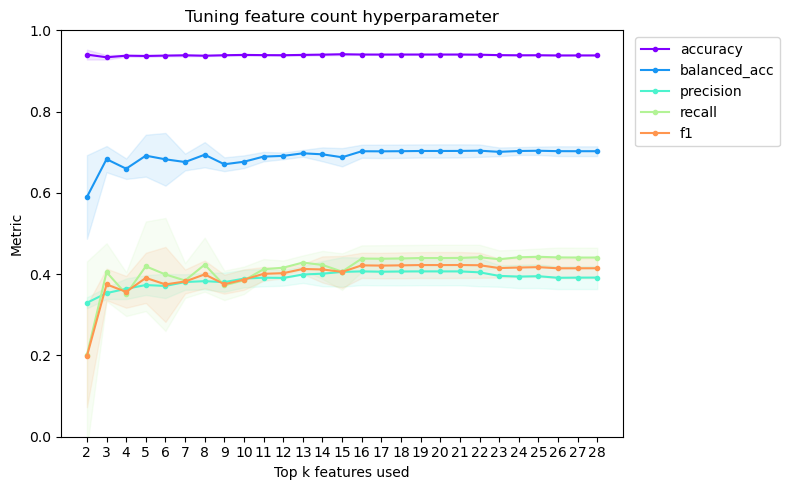

In [111]:
knn_results_1 = get_cv_metrics_df(all_results)

plot_cv_results(
    knn_results_1,
    title="Tuning feature count hyperparameter",
    xlabel="Top k features used",
    out="knn_k_features_tuning.png",
)


Getting the features out


In [112]:
k_folds = 5
k_neighbors = 4
k_features = 13

results = new_k_results()
counter = Counter()
mi_counter = defaultdict(float)

kf_CV = KFold(n_splits=k_folds, shuffle=True, random_state=1)
for train_idx, test_idx in kf_CV.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    fs = SelectKBest(score_func=my_mutual_info_classif, k=k_features)
    fs.fit(X_train, y_train)
    X_train = fs.transform(X_train)
    X_test = fs.transform(X_test)

    knn = KNN(n_neighbors=k_neighbors)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    append_score(results, y_test, y_pred)
    counter.update(X.columns[fs.get_support()])
    for f, s in zip(X.columns[fs.get_support()], fs.scores_):
        mi_counter[f] += s

print(classification_report(y_test, y_pred, target_names=labels))

print(f"k_features={k_features}, ", end=" ")
print({k: np.mean(v) for k, v in results.items()})
selections = pd.DataFrame([counter, mi_counter]).T


              precision    recall  f1-score   support

         DoS       0.42      0.40      0.41       692
       Other       0.97      0.97      0.97     12481

    accuracy                           0.94     13173
   macro avg       0.69      0.69      0.69     13173
weighted avg       0.94      0.94      0.94     13173

k_features=13,  {'accuracy': 0.9395430046306841, 'balanced_acc': 0.6974006517698044, 'precision': 0.39913991763629, 'recall': 0.4285239560314055, 'f1': 0.41274652500299114}


In [113]:
knn_training_df = pd.DataFrame.from_records(results)
knn_training_df


,accuracy,balanced_acc,f1,precision,recall
0,0.939877,0.707398,0.435897,0.424411,0.448023
1,0.939573,0.705675,0.403298,0.366485,0.448333
2,0.942989,0.697782,0.412823,0.399395,0.427184
3,0.936233,0.689500,0.400856,0.388122,0.414454
4,0.939042,0.686648,0.410858,0.417288,0.404624


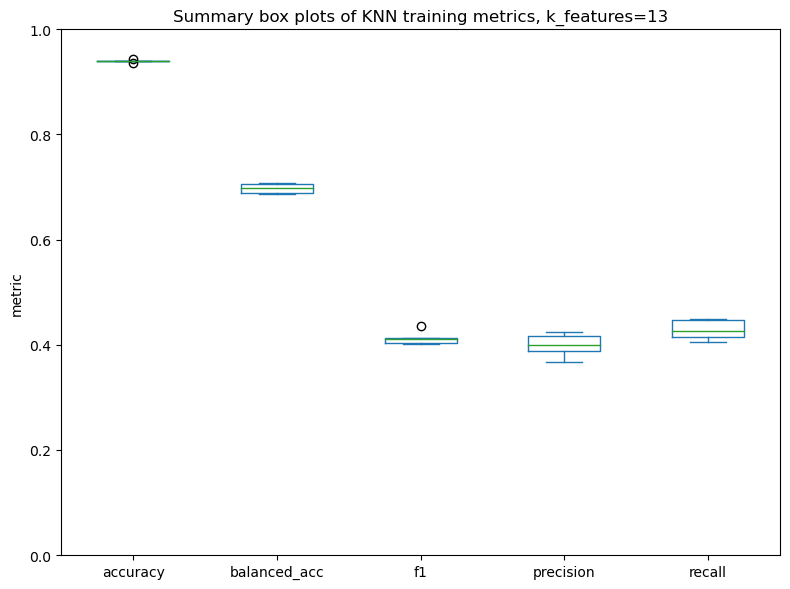

In [114]:
knn_training_df.plot.box(
    ylim=(0, 1),
    figsize=(8, 6),
    ylabel="metric",
    title=f"Summary box plots of KNN training metrics, k_features={k_features}",
)
plt.savefig(make_output_path("knn_training_set_boxplot.png"))
plt.show()


In [115]:
selections = (
    pd.DataFrame([counter, mi_counter])
    .T.reset_index()
    .rename(columns={"index": "feature", 0: "count", 1: "mi"})
    .sort_values(["count", "mi"], ascending=False)
    .reset_index(drop=True)
)
selections


,feature,count,mi
0,rate,5.0,0.355828
1,sinpkt,5.0,0.181694
2,smean,5.0,0.134698
3,dur,5.0,0.126109
4,dttl,5.0,0.112040
5,sload,5.0,0.104119
6,ct_dst_sport_ltm,5.0,0.098396
7,ct_dst_src_ltm,5.0,0.086899
8,dbytes,5.0,0.065965
9,dmean,5.0,0.061744


In [116]:
top_by_count = selections.sort_values(["count"], ascending=False).head(k_features)[
    "feature"
]
top_by_mi = selections.sort_values(["mi"], ascending=False).head(k_features)["feature"]
set(top_by_count) ^ set(top_by_mi)


{'dinpkt', 'sbytes'}

In [117]:
features_2 = selections["feature"].head(k_features).tolist()
features_2


['rate',
 'sinpkt',
 'smean',
 'dur',
 'dttl',
 'sload',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'dbytes',
 'dmean',
 'sbytes',
 'dload',
 'tcprtt']

In [118]:
X_train = X[features_2]
X_test = X_holdout[features_2]
y_train = y
y_test = y_holdout

k_neighbors = 4
k_folds = 5

results = new_k_results()

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn = KNN(n_neighbors=k_neighbors)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

append_score(results, y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=labels))

print(results)


              precision    recall  f1-score   support

         DoS       0.39      0.44      0.41       818
       Other       0.97      0.96      0.97     15649

    accuracy                           0.94     16467
   macro avg       0.68      0.70      0.69     16467
weighted avg       0.94      0.94      0.94     16467

{'accuracy': [0.9378757515030061], 'balanced_acc': [0.6996794439633144], 'precision': [0.3882224645583424], 'recall': [0.4352078239608802], 'f1': [0.41037463976945243]}


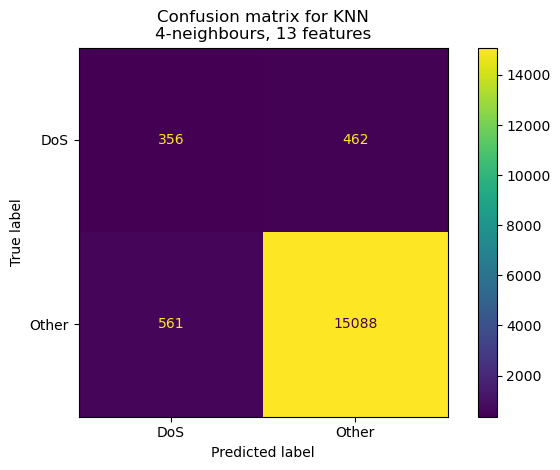

In [119]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title(
    f"Confusion matrix for KNN\n{k_neighbors}-neighbours, {len(features_2)} features"
)
plt.savefig(make_output_path("knn_final_cm.png"))
plt.show()


# Bootstrapping


In [120]:
results = new_k_results()

k_samples = 40
k_neighbors = 4
X_imb = X[features_2].reset_index(drop=True)
y_imb = y.reset_index(drop=True)
n = X_imb.shape[0]

for k in range(k_samples):
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=k)
    _boot_index_set = set(boot_index)
    oob_index = [x for x in range(n) if x not in _boot_index_set]

    X_imb_train = X_imb.loc[boot_index]
    X_imb_test = X_imb.loc[oob_index]
    y_imb_train = y_imb[boot_index]
    y_imb_test = y_imb[oob_index]

    scaler = StandardScaler().fit(X_imb_train)
    X_imb_train = scaler.transform(X_imb_train)
    X_imb_test = scaler.transform(X_imb_test)

    knn = KNN(n_neighbors=k_neighbors)
    knn.fit(X_imb_train, y_imb_train)

    y_imb_pred = knn.predict(X_imb_test)

    append_score(results, y_imb_test, y_imb_pred)


In [121]:
bootstrap_df = pd.DataFrame.from_records(results)
bootstrap_df


,accuracy,balanced_acc,f1,precision,recall
0,0.931632,0.710184,0.406475,0.361716,0.463875
1,0.935439,0.689293,0.383163,0.354440,0.416952
2,0.934443,0.710497,0.405516,0.360982,0.462585
3,0.932163,0.674819,0.366436,0.346686,0.388571
4,0.931955,0.733783,0.420721,0.355832,0.514555
5,0.932164,0.699172,0.402332,0.371217,0.439141
6,0.934763,0.685522,0.386822,0.367452,0.408347
7,0.933573,0.685600,0.379776,0.353448,0.410342
8,0.935218,0.673256,0.364892,0.348332,0.383106
9,0.932291,0.694686,0.388682,0.354138,0.430693


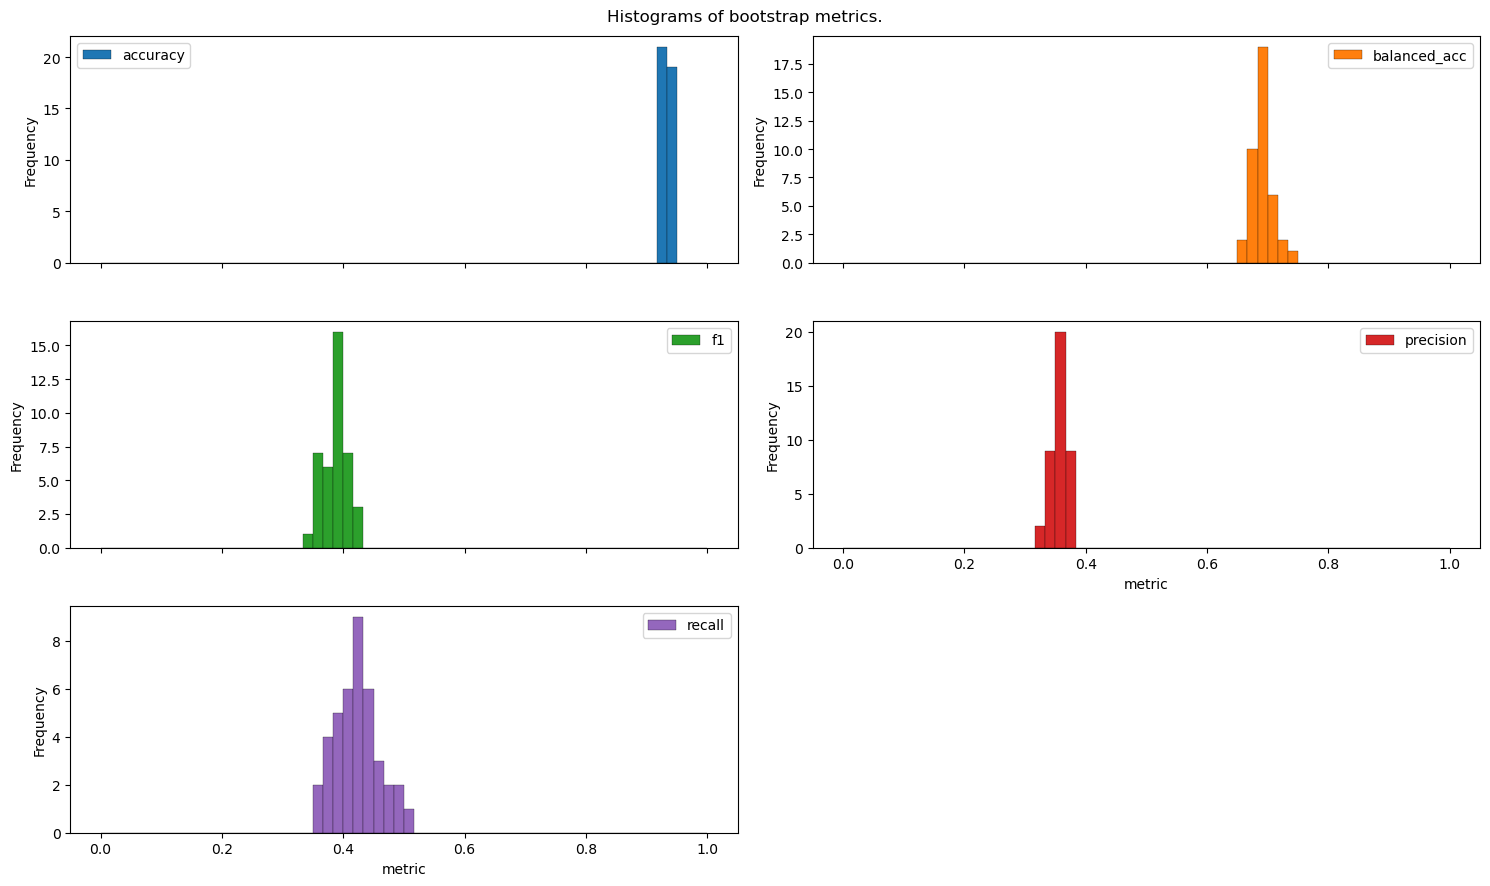

In [122]:
bootstrap_df.plot.hist(
    subplots=True,
    layout=(3, 2),
    bins=60,
    figsize=(15, 9),
    range=(0, 1),
    edgecolor="black",
    linewidth=0.2,
)
axs = plt.gcf().get_axes()
for ax in axs:
    ax.set_xlabel("metric")
plt.suptitle("Histograms of bootstrap metrics.")
plt.savefig(make_output_path("bootstrap_hist.png"))
plt.show()


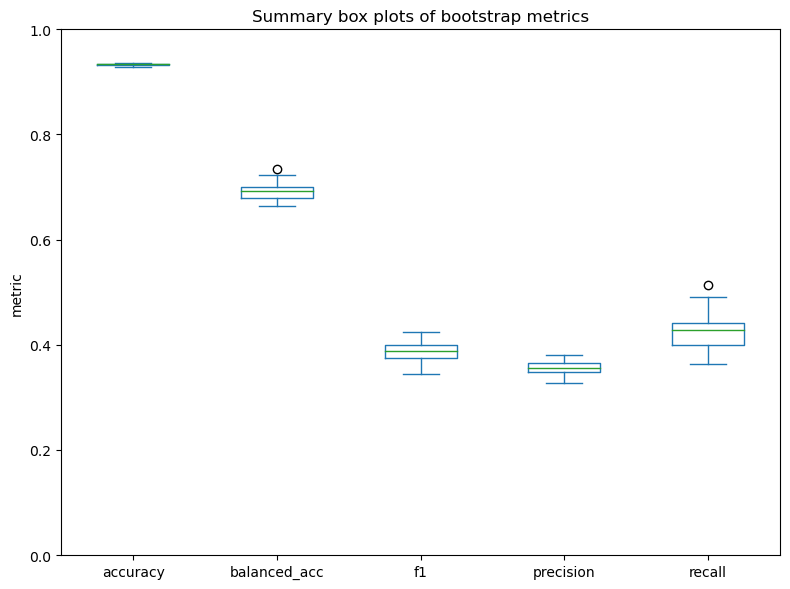

In [123]:
bootstrap_df.plot.box(
    ylim=(0, 1),
    figsize=(8, 6),
    ylabel="metric",
    title="Summary box plots of bootstrap metrics",
)
plt.savefig(make_output_path("bootstrap_boxplot.png"))
plt.show()


In [124]:
def ci_upper(series):
    return series.mean() + 1.96 * series.std()


def ci_lower(series):
    return series.mean() - 1.96 * series.std()


bootstrap_df_stats = bootstrap_df.agg(["median", "std", ci_upper, "mean", ci_lower])
bootstrap_df_stats


,accuracy,balanced_acc,f1,precision,recall
median,0.933249,0.693222,0.387362,0.355346,0.427591
std,0.001627,0.016459,0.019203,0.012190,0.035036
ci_upper,0.936506,0.724364,0.424416,0.380045,0.492944
mean,0.933318,0.692105,0.386779,0.356152,0.424273
ci_lower,0.930130,0.659845,0.349142,0.332259,0.355602


# Decision trees


## Helpers


In [125]:
max_depth_limit = 20


## Decision tree 1


In [126]:
all_results = {}

k_folds = 5
for max_depth in range(1, max_depth_limit + 1):
    kf_CV = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    results = new_k_results()
    for train_idx, test_idx in kf_CV.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        dt = DecisionTreeClassifier(
            criterion="entropy", random_state=1, max_depth=max_depth
        )
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_test)

        append_score(results, y_test, y_pred)

    all_results[max_depth] = results


In [127]:
dt_results_1 = get_cv_metrics_df(all_results)
dt_results_1


,max_depth,accuracy,balanced_acc,precision,recall,f1,accuracy_std,balanced_acc_std,precision_std,recall_std,f1_std
0,1,0.950338,0.500000,0.000000,0.000000,0.000000,0.002855,0.000000,0.000000,0.000000,0.000000
1,2,0.950338,0.500000,0.000000,0.000000,0.000000,0.002855,0.000000,0.000000,0.000000,0.000000
2,3,0.950459,0.503938,0.589444,0.008180,0.016121,0.002824,0.001077,0.057424,0.002213,0.004316
3,4,0.950611,0.503018,0.960000,0.006068,0.012024,0.002828,0.001744,0.080000,0.003538,0.006963
4,5,0.950702,0.503926,0.915152,0.007885,0.015599,0.002817,0.002183,0.129135,0.004372,0.008588
5,6,0.950702,0.504968,0.754048,0.010079,0.019851,0.002787,0.002521,0.116923,0.005054,0.009877
6,7,0.950307,0.508021,0.516585,0.016953,0.032677,0.002871,0.002546,0.135552,0.005315,0.010053
7,8,0.950368,0.512921,0.506610,0.027233,0.051578,0.002934,0.003668,0.089132,0.007381,0.013555
8,9,0.950368,0.516522,0.495653,0.034833,0.064942,0.002946,0.005366,0.077975,0.010808,0.019419
9,10,0.950080,0.522010,0.471545,0.046736,0.084938,0.002570,0.004612,0.072324,0.009154,0.015947


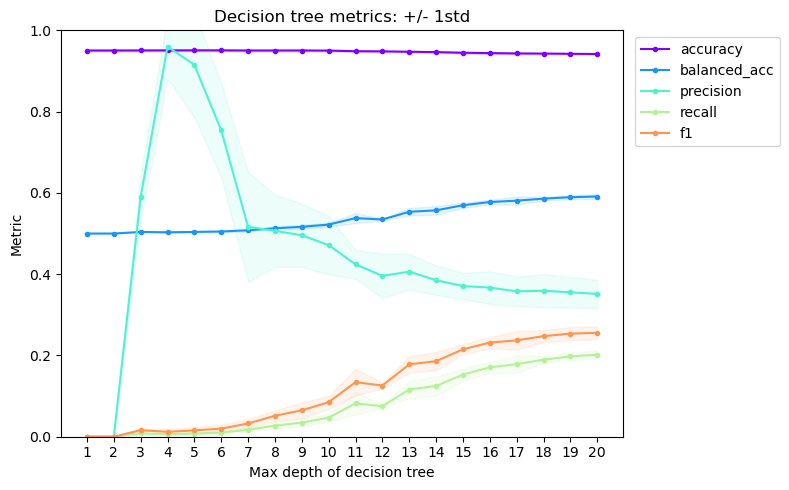

In [128]:
plot_cv_results(
    dt_results_1,
    title="Decision tree metrics: +/- 1std",
    xlabel="Max depth of decision tree",
    out="dt_1_depth_tuning.png",
)


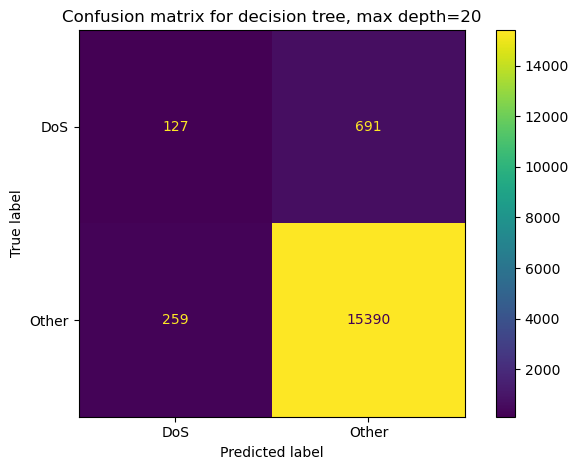

              precision    recall  f1-score   support

         DoS       0.33      0.16      0.21       818
       Other       0.96      0.98      0.97     15649

    accuracy                           0.94     16467
   macro avg       0.64      0.57      0.59     16467
weighted avg       0.93      0.94      0.93     16467

{'accuracy': [0.9423088601445315], 'balanced_acc': [0.569353072702334], 'precision': [0.3290155440414508], 'recall': [0.1552567237163814], 'f1': [0.21096345514950166]}


In [129]:
X_train = X
X_test = X_holdout
y_train = y
y_test = y_holdout

results = new_k_results()
max_depth = 20

dt = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=max_depth)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

append_score(results, y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion matrix for decision tree, max depth=20")
plt.savefig(make_output_path("dt_1_cm.png"))
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))

print(results)


## Balanced weights minority DoS class


In [130]:
all_results = {}

k_folds = 5
for max_depth in range(1, max_depth_limit + 1):
    kf_CV = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    results = new_k_results()
    for train_idx, test_idx in kf_CV.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        dt = DecisionTreeClassifier(
            criterion="entropy",
            random_state=1,
            max_depth=max_depth,
            class_weight="balanced",
        )
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_test)

        append_score(results, y_test, y_pred)

    all_results[max_depth] = results


In [131]:
dt_results_2 = get_cv_metrics_df(all_results)
dt_results_2


,max_depth,accuracy,balanced_acc,precision,recall,f1,accuracy_std,balanced_acc_std,precision_std,recall_std,f1_std
0,1,0.586715,0.726219,0.097030,0.881113,0.174754,0.003958,0.006733,0.006378,0.012789,0.010501
1,2,0.896622,0.763444,0.266067,0.615556,0.371299,0.002732,0.005445,0.009686,0.012997,0.007628
2,3,0.691065,0.813994,0.133431,0.950478,0.233939,0.002037,0.001934,0.007083,0.005613,0.010930
3,4,0.771426,0.853694,0.172207,0.945016,0.291141,0.007057,0.005185,0.011860,0.010024,0.017005
4,5,0.801199,0.857554,0.194012,0.920007,0.318683,0.033526,0.004437,0.029237,0.043813,0.036897
5,6,0.804646,0.872339,0.196153,0.947523,0.324960,0.006506,0.004595,0.007831,0.008026,0.010959
6,7,0.820770,0.875810,0.209292,0.936898,0.341865,0.008166,0.002918,0.014559,0.007730,0.018984
7,8,0.810992,0.875780,0.201638,0.947755,0.332432,0.007791,0.004705,0.010275,0.011564,0.014514
8,9,0.836423,0.877122,0.223186,0.922323,0.359172,0.008425,0.006699,0.015739,0.006780,0.020911
9,10,0.851924,0.876913,0.239285,0.904650,0.378037,0.008725,0.008773,0.021271,0.011182,0.027335


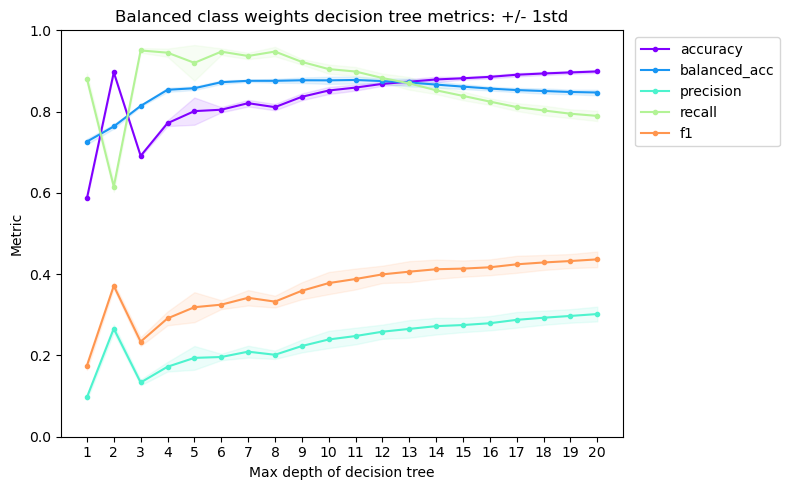

In [132]:
plot_cv_results(
    dt_results_2,
    title="Balanced class weights decision tree metrics: +/- 1std",
    xlabel="Max depth of decision tree",
    out="dt_2_depth_tuning.png",
)


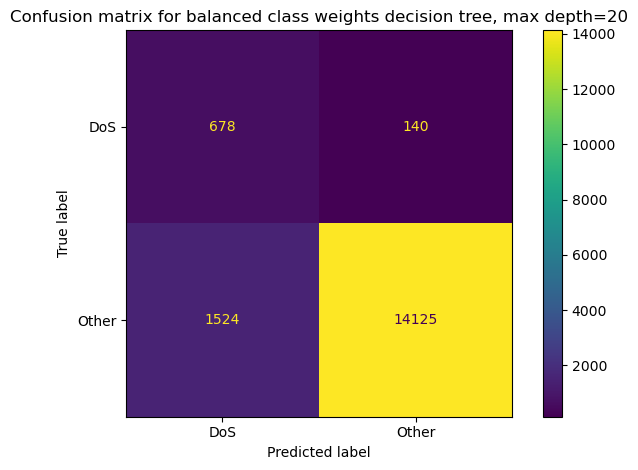

              precision    recall  f1-score   support

         DoS       0.31      0.83      0.45       818
       Other       0.99      0.90      0.94     15649

    accuracy                           0.90     16467
   macro avg       0.65      0.87      0.70     16467
weighted avg       0.96      0.90      0.92     16467

{'accuracy': [0.8989494139794741], 'balanced_acc': [0.8657322206391715], 'precision': [0.3079019073569482], 'recall': [0.8288508557457213], 'f1': [0.44900662251655626]}


In [133]:
X_train = X
X_test = X_holdout
y_train = y
y_test = y_holdout

results = new_k_results()
max_depth = 20

dt = DecisionTreeClassifier(
    criterion="entropy", random_state=1, max_depth=max_depth, class_weight="balanced"
)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

append_score(results, y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion matrix for balanced class weights decision tree, max depth=20")
plt.savefig(make_output_path("dt_2_cm_20.png"), bbox_inches="tight")
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))

print(results)


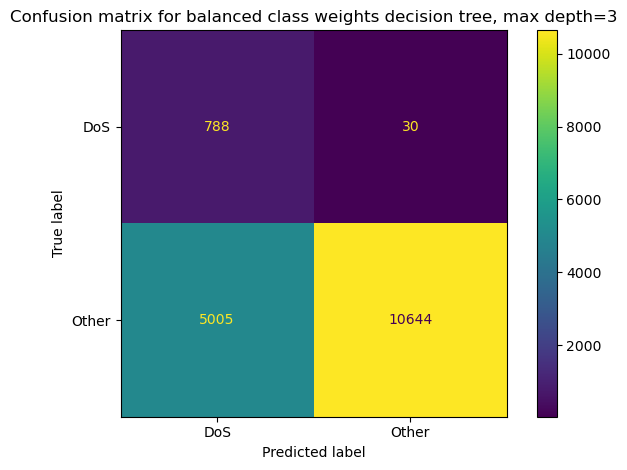

              precision    recall  f1-score   support

         DoS       0.14      0.96      0.24       818
       Other       1.00      0.68      0.81     15649

    accuracy                           0.69     16467
   macro avg       0.57      0.82      0.52     16467
weighted avg       0.95      0.69      0.78     16467

{'accuracy': [0.6942369587660169], 'balanced_acc': [0.8217482201617045], 'precision': [0.13602623856378387], 'recall': [0.9633251833740831], 'f1': [0.2383905611859023]}


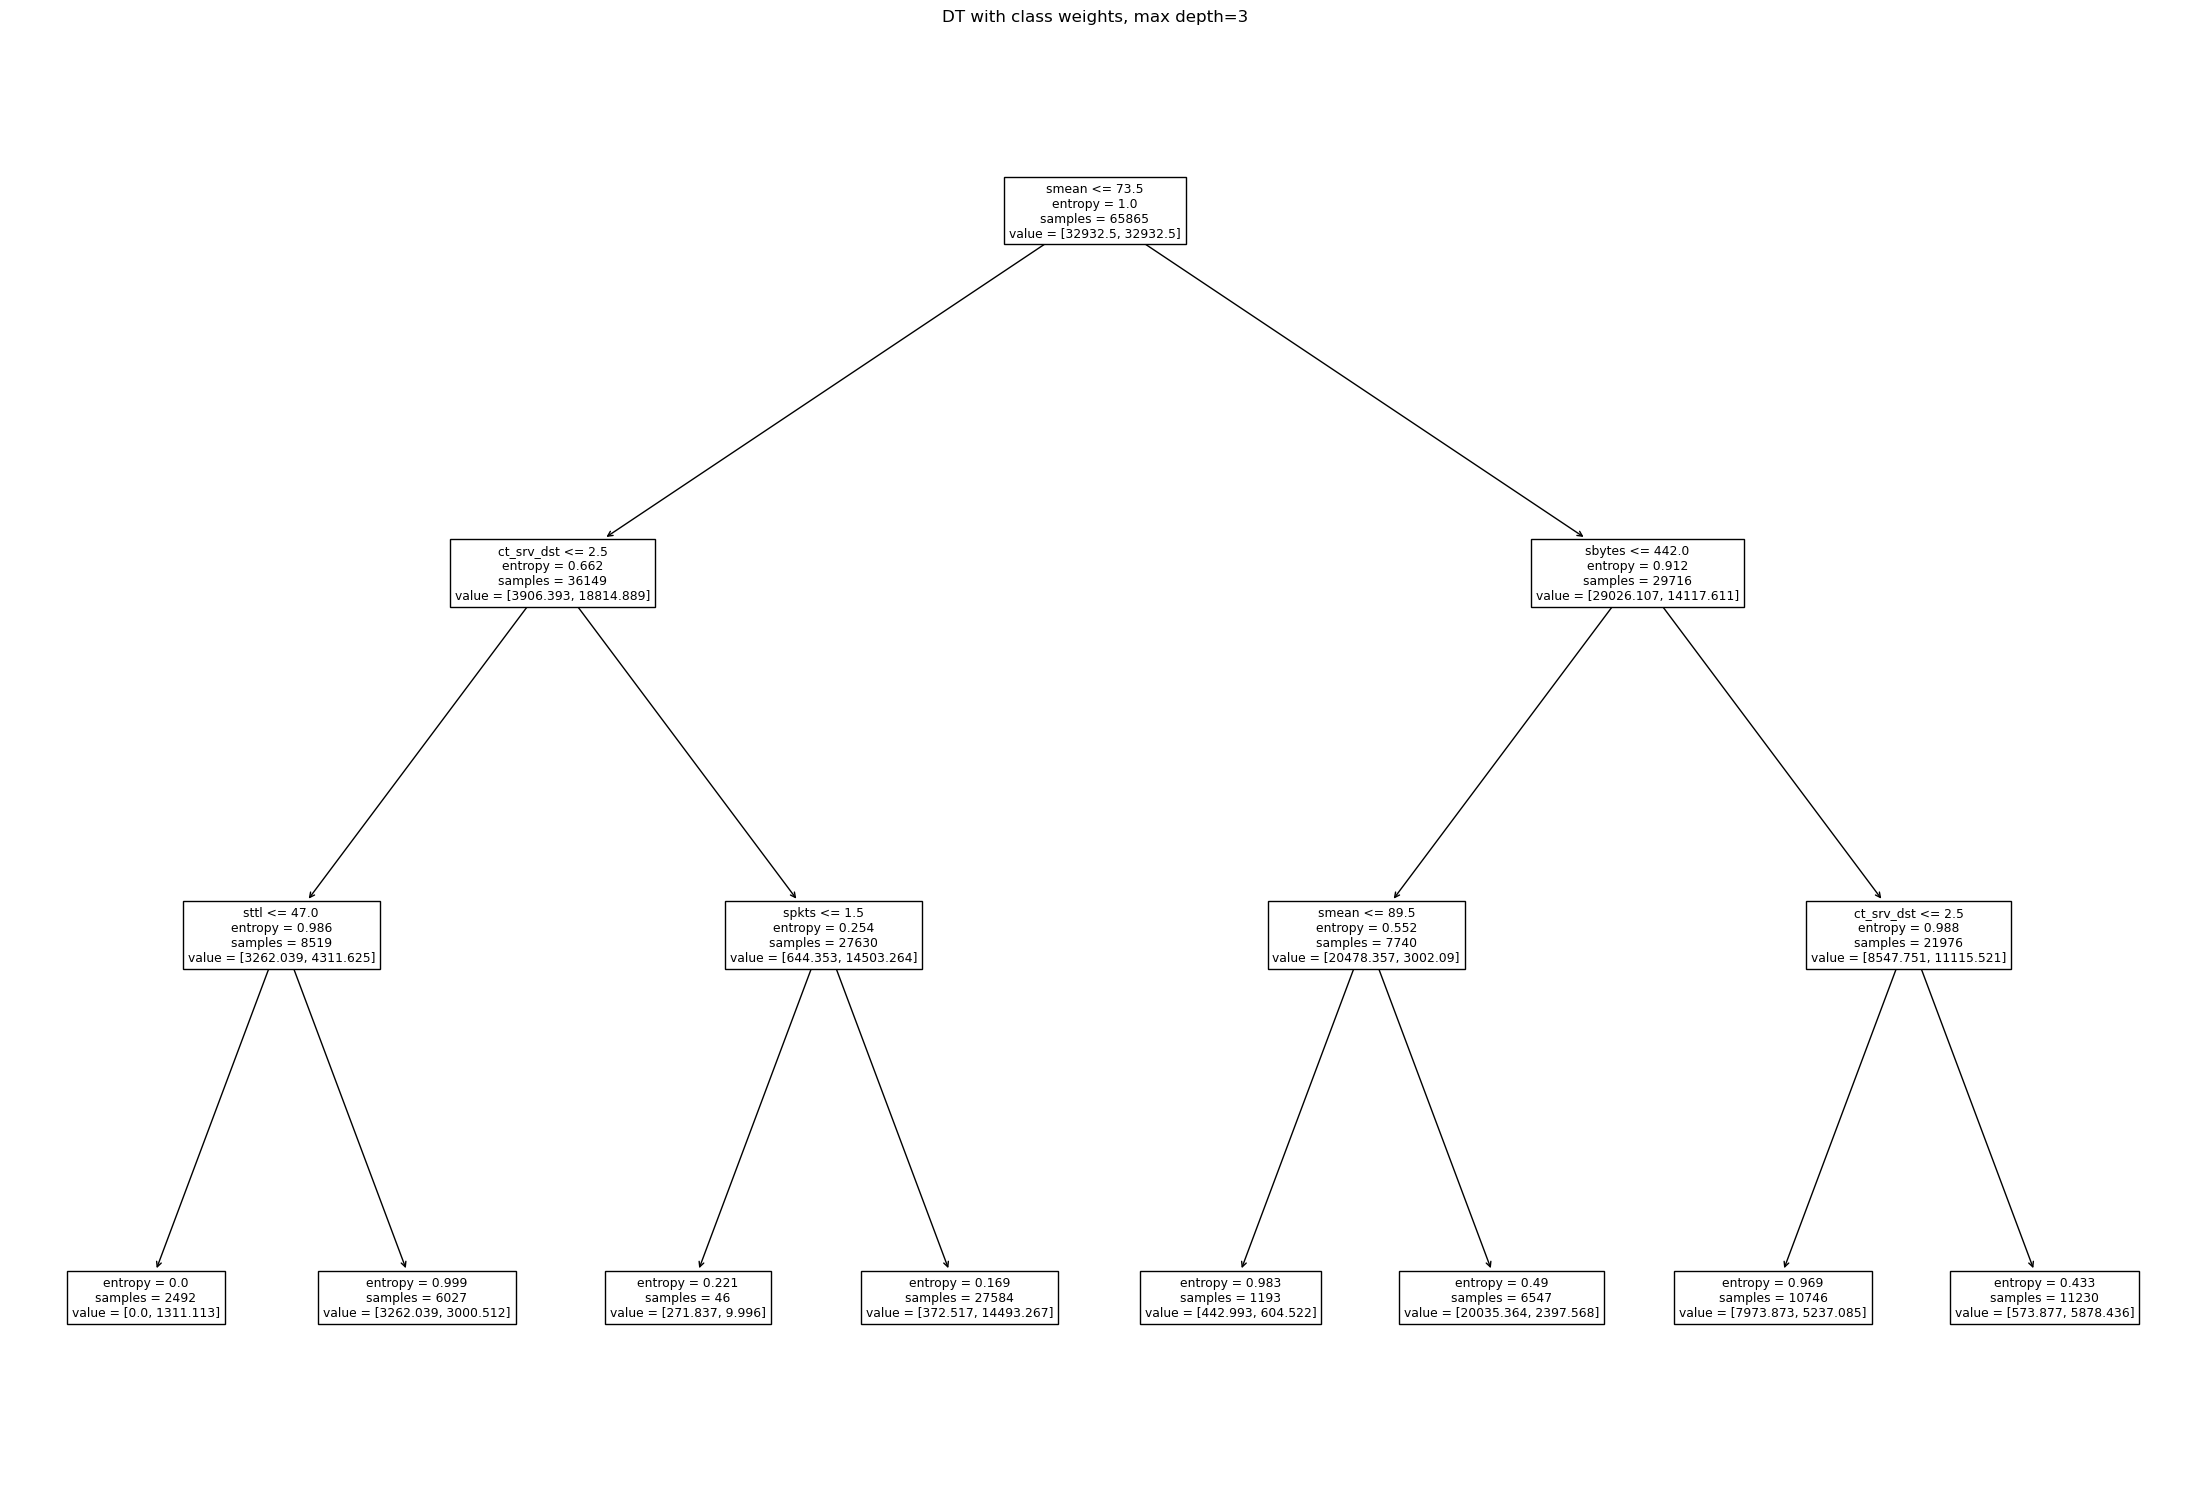

In [134]:
X_train = X
X_test = X_holdout
y_train = y
y_test = y_holdout

results = new_k_results()
max_depth = 3

dt = DecisionTreeClassifier(
    criterion="entropy", random_state=1, max_depth=max_depth, class_weight="balanced"
)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

append_score(results, y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Confusion matrix for balanced class weights decision tree, max depth=3")
plt.savefig(make_output_path("dt_2_cm_3.png"), bbox_inches="tight")
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))

print(results)

plt.figure(figsize=(22, 15))
plot_tree(dt, feature_names=X.columns)
plt.title("DT with class weights, max depth=3")
plt.savefig(make_output_path("dt_2_tree_3.png"), bbox_inches="tight")
plt.show()
